# Monte Carlo Solver: Birth and Death of Photons in a Cavity

Authors: J.R. Johansson and P.D. Nation

Modifications: C. Staufenbiel (2022)

### Introduction

In this tutorial we demonstrate the *Monte Carlo Solver* functionality implemented in `qutip.mcsolve()`. For more information on the *MC Solver* refer to the [QuTiP documentation](https://qutip.readthedocs.io/en/latest/guide/dynamics/dynamics-monte.html). 

We aim to reproduce the experimental results from:



>  Gleyzes et al., "Quantum jumps of light recording the birth and death of a photon in a cavity", [Nature **446**,297 (2007)](http://dx.doi.org/10.1038/nature05589).


In particular, we will simulate the creation and annihilation of photons inside an optical cavity due to the thermal environment when the initial cavity is a single-photon Fock state $ |1\rangle$, as presented in Fig. 3 from the article.

## Imports
First we import the relevant functionalities:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import about, basis, destroy, mcsolve, mesolve

from matplotlib.animation import ArtistAnimation
from IPython.display import HTML
%matplotlib inline

(CVXPY) Aug 12 11:03:49 AM: Encountered unexpected exception importing solver OSQP:
ImportError('DLL load failed while importing qdldl: The specified module could not be found.')


## System Setup
In this example, we consider a simple oscillator Hamiltonian $H = a^\dagger a$ and one initial photon in the cavity.

In [2]:
N = 5  # number of modes in the
a = destroy(N)  # Destroy operator
H = a.dag() * a  # oscillator Hamiltonian
psi0 = basis(N, 1)  # Initial Fock state with one photon

The coupling to the external heat bath is described by a coupling constant $\kappa$ and the temperature of the heat bath is defined via the average photon number $\langle n \rangle$. In QuTiP the interaction between the system and heat bath is defined via the collapse operators. For this example, there are two collapse operators. One for photon annihilation ($C_1$) and one for photon creation ($C_2$): 

$C_1 = \sqrt{\kappa (1 + \langle n \rangle)} \; a$

$C_2 = \sqrt{\kappa \langle n \rangle} \; a^\dagger$

We give some numerical values to the coupling constant $\kappa$ and the average photon number of the heat bath $\langle n \rangle$.

In [3]:
kappa = 1.0 / 0.129  # Coupling rate to heat bath
nth = 0.063  # Temperature with <n>=0.063

# collapse operators for the thermal bath
c_ops = []
c_ops.append(np.sqrt(kappa * (1 + nth)) * a)
c_ops.append(np.sqrt(kappa * nth) * a.dag())

## Monte Carlo Simulation
The *Monte Carlo Solver* allows simulating an individual realization of the system dynamics. This is in contrast to e.g. the *Master Equation Solver*, which solves for the ensemble average over many identical realizations of the system. `qutip.mcsolve()` also offers to average over many runs of identical system setups by passing the *number of trajectories* `ntraj` to the function. If we choose `ntraj = 1` the system is only simulated once and we see it's dynamics. If we choose a large value for `ntraj`, the predictions will be averaged and therefore converge to the solution from `qutip.mesolve()`. 

We can also pass a list to `ntraj`. `qutip.mcsolve()` will calculate the results for the specified number of trajectories. Note that the entries need to be in ascending order, as the previous results are reused.

Here we are interested in the time evolution of $a^\dagger a$ for different numbers of `ntraj`. We will compare the results to the predictions by `qutip.mesolve().

In [17]:
ntraj = [1, 5, 15, 3004]  # number of MC trajectories
mc = []  # MC results
tlist = np.linspace(0, 1.5, 303)

# Solve using MCSolve for different ntraj
for n in ntraj:
    result = mcsolve(H, psi0, tlist, c_ops, [a.dag() * a], ntraj=n, options={"keep_runs_results":True})
    mc.append(result)
me = mesolve(H, psi0, tlist, c_ops, [a.dag() * a])

100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.03s
20.0%. Run time:   0.00s. Est. time left: 00:00:00:00
40.0%. Run time:   0.01s. Est. time left: 00:00:00:00
60.0%. Run time:   0.03s. Est. time left: 00:00:00:00
80.0%. Run time:   0.05s. Est. time left: 00:00:00:00
100.0%. Run time:   0.07s. Est. time left: 00:00:00:00
Total run time:   0.08s
13.3%. Run time:   0.02s. Est. time left: 00:00:00:00
20.0%. Run time:   0.03s. Est. time left: 00:00:00:00
33.3%. Run time:   0.05s. Est. time left: 00:00:00:00
40.0%. Run time:   0.07s. Est. time left: 00:00:00:00
53.3%. Run time:   0.08s. Est. time left: 00:00:00:00
60.0%. Run time:   0.11s. Est. time left: 00:00:00:00
73.3%. Run time:   0.13s. Est. time left: 00:00:00:00
80.0%. Run time:   0.15s. Est. time left: 00:00:00:00
93.3%. Run time:   0.16s. Est. time left: 00:00:00:00
100.0%. Run time:   0.18s. Est. time left: 00:00:00:00
Total run time:   0.20s
10.0%. Run time:   3.09s. Est. time left: 00:00:00:27
20.0%. 

<McResult
  Solver: mcsolve
  Solver stats:
    method: 'adams'
    init time: 0.0
    preparation time: 0.0
    run time: 8.068532705307007
    solver: 'Master Equation Evolution'
    num_collapse: 2
    end_condition: 'ntraj reached'
  Time interval: [0.0, 2.0] (200 steps)
  Number of e_ops: 1
  State not saved.
  Number of trajectories: 904
  Trajectories saved.
>


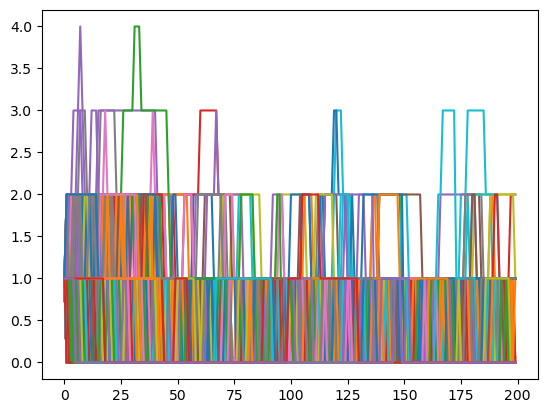

In [5]:
print(result)
#plt.plot(np.array(result.runs_e_data[0]).T)
plt.plot(result.average_expect[0])
plt.plot(result.runs_expect[0].T)

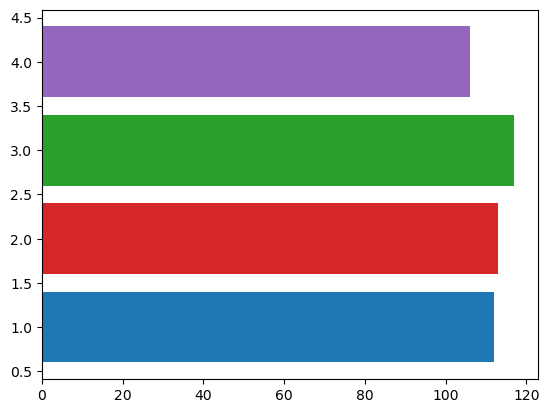

In [6]:
fig, ax = plt.subplots()
rng = np.random.default_rng(19680801)
data = np.array([20, 20, 20, 20])
x = np.array([1, 2, 3, 4])

artists = []
colors = ['tab:blue', 'tab:red', 'tab:green', 'tab:purple']
for i in range(20):
    data += rng.integers(low=0, high=10, size=data.shape)
    container = ax.barh(x, data, color=colors)
    artists.append(container)


ani = ArtistAnimation(fig=fig, artists=artists, interval=400)
plt.show()

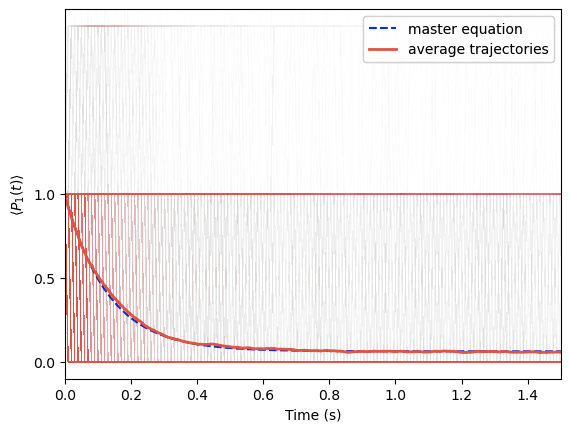

In [28]:
fig, ax = plt.subplots()
selntraj=-1
ims=[]
for i in range(0,len(tlist),len(tlist)//100):
    t3,=ax.plot(tlist[:i], me.expect[0][:i], "--", color="#0030e6", lw=1.5)
    t2,=ax.plot(
        tlist[:i], mc[selntraj].average_expect[0][:i], color="#dF5443FF", lw=2
    )
    l_t1=plt.plot(
        tlist[:i], mc[selntraj].runs_expect[0].T[:i], color="#dF5443%02x"%min(4000//ntraj[selntraj],100), lw=1
    )

    #leg=ax.legend(["master equation", "average %4i trajectories" %i],loc="upper right")
    leg=ax.legend(["master equation", "average trajectories"],loc="upper right")
    ax.add_artist(leg)
    ims.append([t3,t2,*l_t1,leg])
ax.set_yticks([0, 0.5, 1])
ax.set_ylim([-0.1, 2.1])
ax.set_xlim([0, 1.5])
ax.set_ylabel(r"$\langle P_{1}(t)\rangle$")
ax.set_xlabel(r"Time (s)")

ani = ArtistAnimation(fig, ims, interval=5, blit=True)
HTML(ani.to_html5_video())


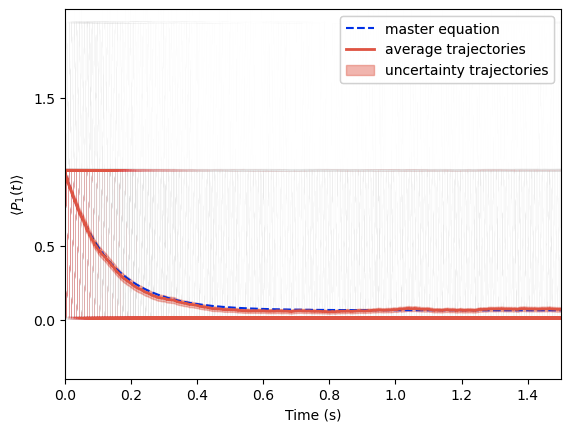

In [18]:
fig, ax = plt.subplots()
selntraj=-1
ims=[]
quadratic_list=np.int32(np.linspace(0,1,40)**2*ntraj[selntraj])
for i in quadratic_list[1:]:
    t3,=ax.plot(tlist, me.expect[0], "--", color="#0030e6", lw=1.5)
    average_i= np.average(mc[selntraj].runs_expect[0].T[:,:i],axis=1)
    std_i= np.std(mc[selntraj].runs_expect[0].T[:,:i],axis=1)*3/np.sqrt(i)
    t2,=ax.plot(
        tlist, average_i, color="#dF5443FF", lw=2
    )
    ta=ax.fill_between(tlist, average_i-std_i, average_i+std_i, color="#dF544360")

    l_t1=plt.plot(
        tlist, np.random.random(i)*0.02+mc[selntraj].runs_expect[0].T[:,:i], color="#dF5443%02x"%min(1+2000//ntraj[selntraj],100), lw=0.5
    )

    #leg=ax.legend(["master equation", "average %4i trajectories" %i],loc="upper right")
    leg=ax.legend(["master equation", "average trajectories", "uncertainty trajectories"],loc="upper right")
    ax.add_artist(leg)
    ims.append([t3,t2,ta,*l_t1,leg])
ax.set_yticks([0, 0.5, 1.5])
ax.set_ylim([-0.4, 2.1])
ax.set_xlim([0, 1.5])
ax.set_ylabel(r"$\langle P_{1}(t)\rangle$")
ax.set_xlabel(r"Time (s)")

ani = ArtistAnimation(fig, ims, interval=100, blit=True)
HTML(ani.to_html5_video())

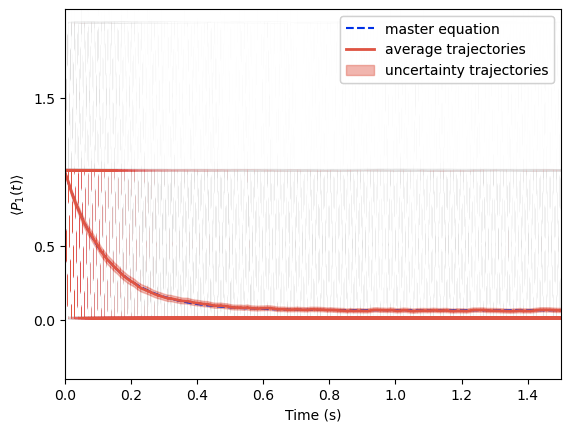

In [16]:
fig, ax = plt.subplots()
selntraj=-1
ims=[]
quadratic_list=np.int32(np.linspace(0,1,40)**2*ntraj[selntraj])
for i in quadratic_list[1:]:
    t3,=ax.plot(tlist, me.expect[0], "--", color="#0030e6", lw=1.5)
    average_i= np.average(mc[selntraj].runs_expect[0].T[:,:i],axis=1)
    std_i= np.std(mc[selntraj].runs_expect[0].T[:,:i],axis=1)*3/np.sqrt(i)
    t2,=ax.plot(
        tlist, average_i, color="#dF5443FF", lw=2
    )
    ta=ax.fill_between(tlist, average_i-std_i, average_i+std_i, color="#dF544360")

    l_t1=plt.plot(
        tlist, np.random.random(i)*0.02+mc[selntraj].runs_expect[0].T[:,:i], color="#dF5443%02x"%min(1+2000//ntraj[selntraj],100), lw=0.5
    )

    #leg=ax.legend(["master equation", "average %4i trajectories" %i],loc="upper right")
    leg=ax.legend(["master equation", "average trajectories", "uncertainty trajectories"],loc="upper right")
    ax.add_artist(leg)
    ims.append([t3,t2,ta,*l_t1,leg])
ax.set_yticks([0, 0.5, 1.5])
ax.set_ylim([-0.4, 2.1])
ax.set_xlim([0, 1.5])
ax.set_ylabel(r"$\langle P_{1}(t)\rangle$")
ax.set_xlabel(r"Time (s)")

ani = ArtistAnimation(fig, ims, interval=100, blit=True)
HTML(ani.to_html5_video())

## Reproduce plot from article
Using the above results we can reproduce Fig. 3 from the article mentioned above. The individual figures plot the time evolution of $\langle a^\dagger a \rangle$ for the system we set up above. The effect of using different `ntraj` for the simulation using `mcsolve` is shown. When choosing `ntraj = 1` we see the dynamics of one particular quantum system. If `ntraj > 1` the output is averaged over the number of realizations. 

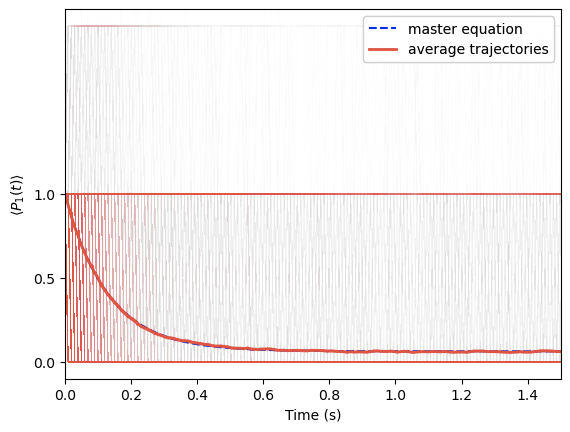

In [11]:
fig, ax = plt.subplots()
selntraj=-1
ims=[]
quadratic_list=np.int32(np.linspace(0,1,20)*ntraj[selntraj])
for i in quadratic_list[1:]:
    t3,=ax.plot(tlist, me.expect[0], "--", color="#0030e6", lw=1.5)
    average_i= np.average(mc[selntraj].runs_expect[0].T[:,:i],axis=1)
    std_i= np.std(mc[selntraj].runs_expect[0].T[:,:i],axis=1)/np.sqrt(i)
    t2,=ax.plot(
        tlist, average_i, color="#dF5443FF", lw=2
    )
    ta=ax.fill_between(tlist, average_i-std_i, average_i+std_i, color="#dF544360")
    l_t1=plt.plot(
        tlist, mc[selntraj].runs_expect[0].T[:,:i], color="#dF5443%02x"%min(4000//ntraj[selntraj],100), lw=1
    )

    #leg=ax.legend(["master equation", "average %4i trajectories" %i],loc="upper right")
    leg=ax.legend(["master equation", "average trajectories"],loc="upper right")
    ax.add_artist(leg)
    ims.append([t3,t2,ta,*l_t1,leg])
ax.set_yticks([0, 0.5, 1])
ax.set_ylim([-0.1, 2.1])
ax.set_xlim([0, 1.5])
ax.set_ylabel(r"$\langle P_{1}(t)\rangle$")
ax.set_xlabel(r"Time (s)")

ani = ArtistAnimation(fig, ims, interval=50, blit=True)
HTML(ani.to_html5_video())

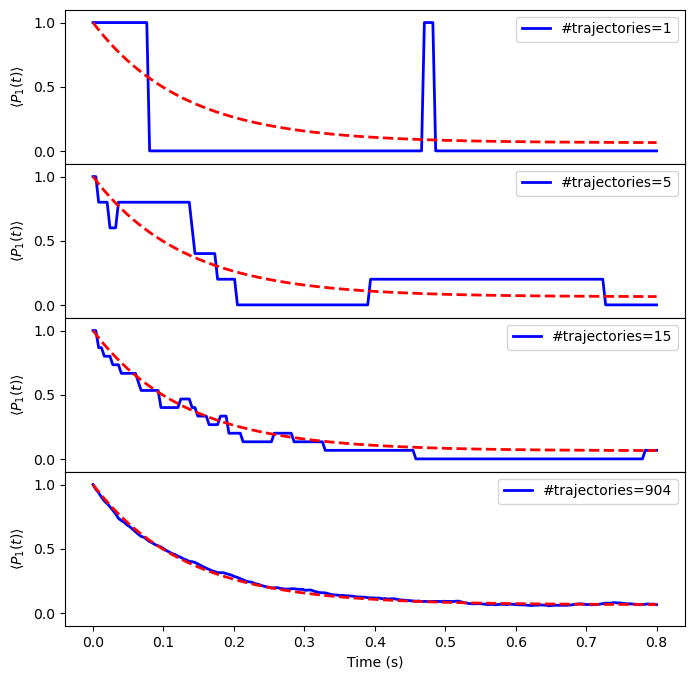

In [31]:
fig = plt.figure(figsize=(8, 8), frameon=False)
plt.subplots_adjust(hspace=0.0)

for i in range(len(ntraj)):
    ax = plt.subplot(4, 1, i + 1)
    ax.plot(
        tlist, mc[i].average_expect[0], "b", lw=2,
        label="#trajectories={}".format(ntraj[i])
    )
    ax.plot(tlist, me.expect[0], "r--", lw=2)
    ax.set_yticks([0, 0.5, 1])
    ax.set_ylim([-0.1, 1.1])
    ax.set_ylabel(r"$\langle P_{1}(t)\rangle$")
    ax.legend()

ax.set_xlabel(r"Time (s)");

## About

In [6]:
about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Jake Lishman, Simon Cross, Asier Galicia, Paul Menczel, and Patrick Hopf.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      5.1.0.dev0+c874c4a
Numpy Version:      1.22.4
Scipy Version:      1.13.1
Cython Version:     3.0.10
Matplotlib Version: 3.5.2
Python Version:     3.10.4
Number of CPUs:     4
BLAS Info:          Generic
INTEL MKL Ext:      False
Platform Info:      Linux (x86_64)
Installation path:  /usr/share/miniconda3/envs/test-environment/lib/python3.10/site-packages/qutip
Please cite QuTiP in your publication.
For your convenience a bi

## Testing

In [7]:
np.testing.assert_allclose(me.expect[0], mc[3].expect[0], atol=10**-1)
assert np.all(np.diff(me.expect[0]) <= 0)